# Light GBM

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model packages
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from time import time
import pprint
import joblib
from functools import partial

from sklearn.model_selection import KFold, StratifiedKFold
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# Skopt functions
# conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

path = '/home/jln436/Internship_AUMC/'

In [2]:
# Initialize some variables that will be consistent throughout
n_folds = 5 # For stratified cross-validatio
random_seed = 42
nbins = 10 # For stratified K-fold

In [3]:
# Load training sets
df = pd.read_csv(path + 'output/dfs/X_train_final.csv')
target = pd.read_csv(path + 'output/dfs/y_train_final.csv')

In [4]:
# Remove id number because not useful for predictions
df.drop(columns = ['respnr'], inplace = True)

In [5]:
# Split into training and validation set:
X, X_val, y, y_val = train_test_split(df, target.target, test_size=0.30, random_state=random_seed)
# Stratifying the target
y_stratified = pd.cut(y, bins=nbins, labels=False)

In [6]:
#Scale features
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

# Bayesian Hyper-parameter tuning:

In [7]:
# Helpful Links:
## explanation: https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
## tutorial: https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook

In [8]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params, d

In [9]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

In [10]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=n_folds, 
                      shuffle=True, 
                      random_state=random_seed)

cv_strategy = list(skf.split(X, y_stratified))

In [11]:
# Setting the basic regressor
reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        objective='regression',
                        metric='rmse',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=random_seed)

In [12]:
# Setting the search space
search_spaces = {
    'boosting_type': Categorical(['gbdt', 'dart']), # Boosting type
    'reg_sqrt': Categorical([True, False]),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'tree_learner': Categorical(['serial','feature','data','voting']),          # Type of tree learning method
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
    'feature_fraction': Real(0.01, 1.0, 'uniform'),      # Fraction of features to select for model tuning
    'max_bin': Integer(2, 300),                          # Set the max number of bins
    'min_data_in_leaf': Integer(0,60)                    # Minimum amount of data in each lear
   }

In [13]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                           
                    cv=cv_strategy,                                           
                    n_iter=100,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [14]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 7) # We impose a time limit (7 hours)

best_params, d = report_perf(opt, X, y,'LightGBM_regression', 
                          callbacks=[overdone_control, time_limit_control])

LightGBM_regression took 636.15 seconds,  candidates checked: 100, best CV score: -3.402 ± 0.342
Best parameters:
OrderedDict([('boosting_type', 'gbdt'),
             ('colsample_bytree', 0.10380922914376393),
             ('feature_fraction', 0.22186280898586927),
             ('learning_rate', 0.01),
             ('max_bin', 22),
             ('max_depth', 219),
             ('min_data_in_leaf', 29),
             ('n_estimators', 2035),
             ('num_leaves', 216),
             ('reg_alpha', 2.0544905388063234e-06),
             ('reg_lambda', 3.52304142349351e-05),
             ('reg_sqrt', False),
             ('subsample', 0.9209050072166302),
             ('subsample_freq', 2),
             ('tree_learner', 'serial')])



In [15]:
# Look at all the results
(d.rank_test_score == 1).sum()

1

In [16]:
best_params

OrderedDict([('boosting_type', 'gbdt'),
             ('colsample_bytree', 0.10380922914376393),
             ('feature_fraction', 0.22186280898586927),
             ('learning_rate', 0.01),
             ('max_bin', 22),
             ('max_depth', 219),
             ('min_data_in_leaf', 29),
             ('n_estimators', 2035),
             ('num_leaves', 216),
             ('reg_alpha', 2.0544905388063234e-06),
             ('reg_lambda', 3.52304142349351e-05),
             ('reg_sqrt', False),
             ('subsample', 0.9209050072166302),
             ('subsample_freq', 2),
             ('tree_learner', 'serial')])

### Evaluate the best parameters

In [17]:
# Make predictions on the validation data set:
# Transferring the best parameters to our basic regressor
model = lgb.LGBMRegressor(objective='regression',
                        metric='rmse',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=random_seed,
                        **best_params)

In [18]:
model.fit(X, y)
# Make predictions:
y_pred = model.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.22186280898586927, colsample_bytree=0.10380922914376393 will be ignored. Current value: feature_fraction=0.22186280898586927
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


In [19]:
# accuracy check
mse = mean_squared_error(y_val, y_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(y_val, y_pred)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 2.60
MSE: 11.22
RMSE: 3.35


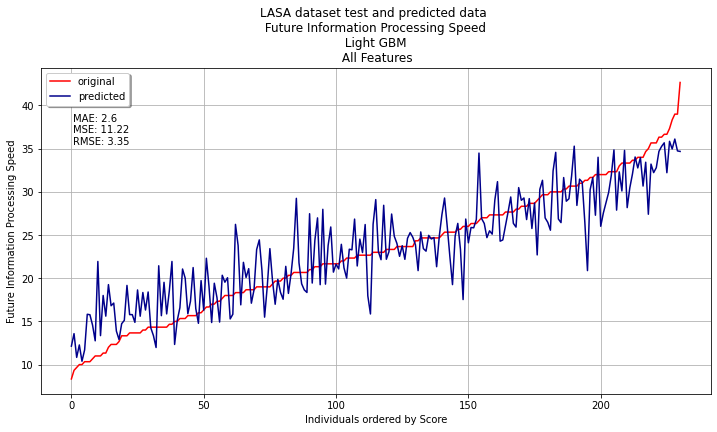

In [20]:
tmp_df = pd.DataFrame(data = y_val)
tmp_df['predicted'] = y_pred
tmp_df = tmp_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(y_val))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, tmp_df.target, label="original", color = "red")
plt.plot(x_ax, tmp_df.predicted, label="predicted", color = "darkblue")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Light GBM \n All Features")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 35.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

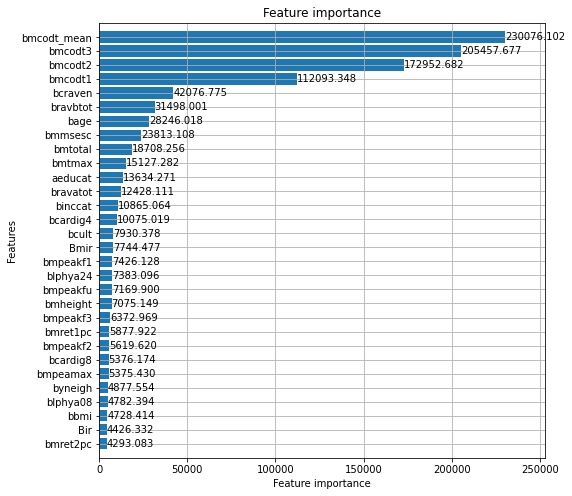

In [21]:
# plotting feature importance
fig = lgb.plot_importance(model, height=.8, max_num_features = 30, figsize = (8,8), importance_type = 'gain')

In [22]:
feature_imp_gain = pd.DataFrame({'Value':model.booster_.feature_importance(importance_type = 'gain'),'features':X.columns})
feature_imp_gain = feature_imp_gain.sort_values('Value', ascending = False)
# Save feature importances
feature_imp_gain.to_csv(path + 'output/Importances/LightGBM_Importances_gain.csv', index = False)

## Save Training Model

In [23]:
import pickle
filename = path + '/output/models/lightGBM_bayesian_training_model.sav'

In [24]:
# save the model to disk
pickle.dump(model, open(filename, 'wb'))

In [25]:
# load the model from disk
model = pickle.load(open(filename, 'rb'))
